In [2]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from transformers import BertTokenizer, BertModel

C:\Users\Shaun\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Shaun\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
BBertSentData= pd.read_csv('BalancedProcessedBERTSentimentData.csv')

In [3]:
BBertSentData

,Unnamed: 0,class,tweet,Sentiment,Score
0,0,2,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,3,1,look like tranny,Negative,0.673002
4,4,1,shit hear might true might faker bitch told ya,Negative,0.695477
...,...,...,...,...,...
4795,4795,0,put pant whore dont let pussy hang,Negative,0.823633
4796,4796,0,kill,Neutral,0.483679
4797,4797,0,aint way gon na catch stan aint faggot + curb ...,Negative,0.728758
4798,4798,0,stay mad faggot hang,Negative,0.932202


In [15]:
from transformers import BertModel

# Load pre-trained BERT model for embedding extraction
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to get embeddings from the BERT model
def get_bert_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings from the [CLS] token (first token)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

# Get embeddings for train and test sets
train_embeddings = get_bert_embeddings(train_texts, tokenizer, bert_model)
test_embeddings = get_bert_embeddings(test_texts, tokenizer, bert_model)

# Convert torch tensors to numpy arrays for use with sklearn
train_embeddings_np = train_embeddings.numpy()
test_embeddings_np = test_embeddings.numpy()



C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define the SVM classifier with the given parameters
svm_model = svm.SVC(C=0.1, kernel='linear', class_weight={0: 2, 1: 1, 2: 1}, degree=2, gamma='scale')

# Train the SVM classifier on BERT embeddings
svm_model.fit(train_embeddings_np, train_labels)

# Make predictions on the test set
svm_predictions = svm_model.predict(test_embeddings_np)

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
# Save the trained model and tokenizer
model_save_path = './bert-SVM-hate-offensive-model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


In [ ]:
# Evaluate the model
print(f"Accuracy: {accuracy_score(test_labels, svm_predictions)}")
print(classification_report(test_labels, svm_predictions, target_names=['Hate', 'Offensive', 'Neither']))

# Generate confusion matrix
cm = confusion_matrix(test_labels, svm_predictions)

# Visualize the confusion matrix using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## BERT SVM with grid search for best parameters

In [8]:
# Load pre-trained BERT model for embedding extraction
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    BBertSentData['tweet'].astype(str), BBertSentData['class'].astype(str), test_size=0.2, random_state=42
)
# Function to get embeddings from the BERT model
def get_bert_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings from the [CLS] token (first token)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

# Get embeddings for train and test sets
train_embeddings = get_bert_embeddings(train_texts, tokenizer, bert_model)
test_embeddings = get_bert_embeddings(test_texts, tokenizer, bert_model)

# Convert torch tensors to numpy arrays for use with sklearn
train_embeddings_np = train_embeddings.numpy()
test_embeddings_np = test_embeddings.numpy()


In [9]:
from sklearn.svm import SVC
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'degree': [2, 3, 4],  # Degree for polynomial kernel (ignored by other kernels)
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'class_weight': [{0: 3, 1: 1, 2: 1.25}, {0: 2, 1: 1, 2: 1}, 'balanced'],  # Class weights
}

# GridSearchCV for parameter tuning
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_embeddings_np, train_labels)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(train_embeddings_np, train_labels)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


C:\Users\Shaun\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
480 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Shaun\anaconda3\lib\site-packages\numpy\core\fromnumeric.py", line 59, in _wrapfunc
    return bound(*args, **kwds)
TypeError: '<' not supported between instances of 'str' and 'int'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Shaun\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  F

Best Parameters: {'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.7192708333333333


SVC(C=10, class_weight='balanced', degree=2)

In [12]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(train_embeddings_np, train_labels)

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define the SVM classifier with the given parameters
svm_model = svm.SVC(C=10, kernel='rbf', degree=2, gamma='scale')

# Train the SVM classifier on BERT embeddings
svm_model.fit(train_embeddings_np, train_labels)

# Make predictions on the test set
svm_predictions = svm_model.predict(test_embeddings_np)

Accuracy: 0.7479166666666667
              precision    recall  f1-score   support

        Hate       0.72      0.67      0.69       314
   Offensive       0.74      0.76      0.75       321
     Neither       0.78      0.82      0.80       325

    accuracy                           0.75       960
   macro avg       0.75      0.75      0.75       960
weighted avg       0.75      0.75      0.75       960



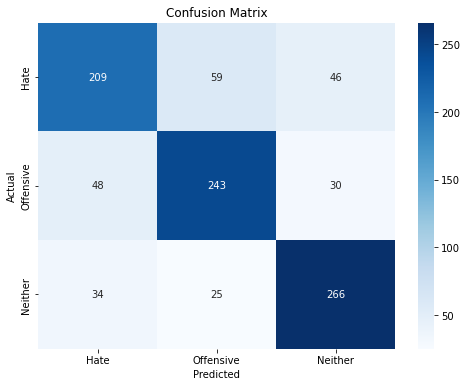

In [13]:
# Evaluate the model
print(f"Accuracy: {accuracy_score(test_labels, svm_predictions)}")
print(classification_report(test_labels, svm_predictions, target_names=['Hate', 'Offensive', 'Neither']))

# Generate confusion matrix
cm1 = confusion_matrix(test_labels, svm_predictions)

# Visualize the confusion matrix using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [14]:
import joblib

# Save the SVM model
model_save_path = './svm-hate-offensive-model.joblib'
joblib.dump(svm_model, model_save_path)


['./svm-hate-offensive-model.joblib']

## With Full dataset

In [3]:
FullData= pd.read_csv('DataSentiment3class.csv')

In [ ]:
# Load pre-trained BERT model for embedding extraction
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    FullData['tweet'].astype(str), FullData['class'].astype(str), test_size=0.2, random_state=42
)
# Function to get embeddings from the BERT model
def get_bert_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings from the [CLS] token (first token)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]
    return cls_embeddings

# Get embeddings for train and test sets
train_embeddings = get_bert_embeddings(train_texts, tokenizer, bert_model)
test_embeddings = get_bert_embeddings(test_texts, tokenizer, bert_model)

# Convert torch tensors to numpy arrays for use with sklearn
train_embeddings_np = train_embeddings.numpy()
test_embeddings_np = test_embeddings.numpy()

from sklearn.svm import SVC
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'degree': [2, 3, 4],  # Degree for polynomial kernel (ignored by other kernels)
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'class_weight': [{0: 3, 1: 1, 2: 1.25}, {0: 2, 1: 1, 2: 1}, 'balanced'],  # Class weights
}

# GridSearchCV for parameter tuning
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(train_embeddings_np, train_labels)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(train_embeddings_np, train_labels)

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(train_embeddings_np, train_labels)

from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define the SVM classifier with the given parameters
svm_model = svm.SVC(C=10, kernel='rbf', degree=2, gamma='scale')

# Train the SVM classifier on BERT embeddings
svm_model.fit(train_embeddings_np, train_labels)

# Make predictions on the test set
svm_predictions = svm_model.predict(test_embeddings_np)

# Evaluate the model
print(f"Accuracy: {accuracy_score(test_labels, svm_predictions)}")
print(classification_report(test_labels, svm_predictions, target_names=['Hate', 'Offensive', 'Neither']))

# Generate confusion matrix
cm1 = confusion_matrix(test_labels, svm_predictions)

# Visualize the confusion matrix using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
